In [2]:
using Pkg; Pkg.activate("..")

using CSV, DataFrames
using Plots, StatsPlots, Plots.PlotMeasures, CairoMakie
using StatsBase, Random

include("../src/utils.jl")
include("../src/heatmap.jl")

  Activating project at `~/ben/chimera_detection/CHMMAIRRaAnalyses`


cocc_heatmap_dendograms_CairoMakie (generic function with 1 method)

This notebook is for exploring trends in single recombination chimeras

In [2]:
# INPUTS
# each dataset is a directory in the data/igdiscover22/ directory
# for each dataset, there is a collected/ directory with the collected files
datasets = ["GKH_TCR", "PRJNA308641", "IML369", "PRJNA300878"]
igdiscover_dir = "../../data/igdiscover22/"
collected_CHMMAIRRa_files = [joinpath(igdiscover_dir, dataset, "collected", "collected_CHMMAIRRa_out.tsv.gz") for dataset in datasets]

# OUTPUTS
# where to save plots
plots_dir = "../../outputs/plots"

"../../outputs/plots"

In [3]:
# databases and genomic order information are provided with the repository
KITDB_dir = joinpath(@__DIR__, "../data/KI_TCR_DB_v0.0.1")  # See https://gkhlab.gitlab.io/tcr/sequences/
OGRDB_dir = joinpath(@__DIR__, "../data/OGRDB_human_IGH_9") # See https://ogrdb.airr-community.org/germline_sets/Homo%20sapiens
IGH_human_order_file = joinpath(@__DIR__, "../data/human_IGH_VDJ_gene_genomic_order.tsv")
TCR_human_order_file = joinpath(@__DIR__, "../data/human_TCR_VDJ_gene_genomic_order.tsv")

# random seed
random_seed = 888
rng = MersenneTwister(random_seed)

global chains = ["IGM", "IGG", "TRA", "TRB", "TRD", "TRG"]
global chain2coord = Dict("IGM" => 1.0, "IGG" => 2.0, "TRA" => 3.0, "TRB" => 4.0, "TRD" => 5.0, "TRG" => 6.0);

# Read/Augment files

In [4]:
chimeric, nonchimeric, library_cts = load_collected_files(collected_CHMMAIRRa_files)
chimeric = augment_collected_df(chimeric);
nonchimeric = augment_collected_df(nonchimeric);
chimeric[!,"nrecombinations"] = map(el->ismissing(el) ? missing : count(x->x==';', el) + 1, chimeric.recombinations);

println("$(floor(sum(ismissing.(chimeric.recombinations)) / nrow(chimeric) * 100))% of chimeric assignments are missing recombination information");
println("$(floor(sum( (.! ismissing.(chimeric.nrecombinations)) .& (chimeric.nrecombinations .!= 1)) / nrow(chimeric) * 100))% of chimeric assignments have nrecombinations != 1");
println("Chimeric assignments missing recombination information or having nrecombinations != 1 were removed")
chimeric = chimeric[.! ismissing.(chimeric.nrecombinations) .& (chimeric.nrecombinations .== 1),:];

┌ Info: GKH_TCR
└ @ Main /home/mchernys/ben/chimera_detection/chimera_detection/src/utils.jl:236
┌ Info: PRJNA308641
└ @ Main /home/mchernys/ben/chimera_detection/chimera_detection/src/utils.jl:236
┌ Info: IML369
└ @ Main /home/mchernys/ben/chimera_detection/chimera_detection/src/utils.jl:236
┌ Info: PRJNA300878
└ @ Main /home/mchernys/ben/chimera_detection/chimera_detection/src/utils.jl:236


2.0% of chimeric assignments are missing recombination information
3.0% of chimeric assignments have nrecombinations != 1
Chimeric assignments missing recombination information or having nrecombinations != 1 were removed


In [5]:
# get V gene ordering for plotting
TCR_gene_order = CSV.read(TCR_human_order_file, DataFrame, delim = "\t")[!,"gene"]
expressed_v_genes = unique(vcat(chimeric.v_gene, nonchimeric.v_gene))
gene_order = Dict()
for chain in ["TRA", "TRB", "TRD", "TRG"]
    gene_order["V_genomic_$(chain)"] = filter(gene -> occursin("$(chain)V", gene) & (gene in expressed_v_genes), TCR_gene_order)
end
# genomic data contains Ds, Js, and non-expressed Vs. We remove those using the conditions in this lis comprehension
gene_order["V_genomic_IGH"]= [gene for gene in DataFrame(CSV.File(IGH_human_order_file))[!,"gene"] if occursin("V", gene) & (gene in expressed_v_genes)];
gene_order["V_genomic_IGM"], gene_order["V_genomic_IGG"] = gene_order["V_genomic_IGH"], gene_order["V_genomic_IGH"]

(String15["IGHV6-1", "IGHV1-2", "IGHV1-3", "IGHV4-4", "IGHV7-4-1", "IGHV2-5", "IGHV3-7", "IGHV1-8", "IGHV3-9", "IGHV5-10-1"  …  "IGHV3-64", "IGHV3-66", "IGHV1-69", "IGHV3-69-1", "IGHV2-70D", "IGHV2-70", "IGHV1-69-2", "IGHV3-72", "IGHV3-73", "IGHV3-74"], String15["IGHV6-1", "IGHV1-2", "IGHV1-3", "IGHV4-4", "IGHV7-4-1", "IGHV2-5", "IGHV3-7", "IGHV1-8", "IGHV3-9", "IGHV5-10-1"  …  "IGHV3-64", "IGHV3-66", "IGHV1-69", "IGHV3-69-1", "IGHV2-70D", "IGHV2-70", "IGHV1-69-2", "IGHV3-72", "IGHV3-73", "IGHV3-74"])

# Chimeric % per library scatterplots (Figure 6)

In [6]:
# determines the frequency at which a recombination occurs between differing genes
function diff_gene_func(df)
    sub_df = df[( .! ismissing.(df.recombinations_degapped)),:]
    recombinations = parse_recombinations_string.(sub_df.recombinations_degapped)
    # bit vector of whether all genes in the recombination are the same
    same_gene = all.(map(x -> map(x -> split(x.left_allele, "*")[1] != split(x.right_allele, "*")[1], x), recombinations))
    return DataFrame(frequency = sum(same_gene) / length(same_gene), chain_coord = df.chain_coord[1], chain = df.chain[1])
end

# determines the frequency at which a recombination occurs between the same gene family
function same_family_func(df)
    sub_df = df[( .! ismissing.(df.recombinations_degapped)),:]
    recombinations = parse_recombinations_string.(sub_df.recombinations_degapped)
    # bit vector of whether all genes in the recombination are the same family
    same_family = all.(map(x -> map(x -> split(x.left_allele, "-")[1] == split(x.right_allele, "-")[1], x), recombinations))
    return DataFrame(frequency = sum(same_family) / length(same_family), chain_coord = df.chain_coord[1])
end

intergenic_freq_df = combine(diff_gene_func, groupby(chimeric, :case))
intergenic_freq_df[!,"percent"] = intergenic_freq_df.frequency .* 100

GKH_TCR_donors = chimeric[chimeric.dataset_id .== "GKH_TCR","donor"]
donors_missing_TRD = setdiff(GKH_TCR_donors, chimeric[occursin.("TRD", chimeric.startingpoint),"donor"])
TRD_zeros = DataFrame("case" => "TRD_" .* donors_missing_TRD, "chain" .=> "TRD", "n" .=> 0, "frequency" .=> 0.0, "percent" .=> 0.0, "dataset_id" .=> "GKH_TCR")
TRD_zeros[!,"chain_coord"] .= -1
TRD_zeros[!,"chain_coord"] = jitter(map(function(x) chain2coord[x] end, TRD_zeros[!,"chain"]), variance = 2);
append!(intergenic_freq_df, TRD_zeros, cols = :union)


same_family_freq_df = combine(same_family_func, groupby(chimeric, :case))
same_family_freq_df[same_family_freq_df.frequency .> 0.0,:]
same_family_freq_df[!,"percent"] = same_family_freq_df.frequency .* 100
same_family_freq_df = same_family_freq_df[ .! (occursin.("TRD", same_family_freq_df.case) .| occursin.("TRG", same_family_freq_df.case)),:]


function first_el(arr)
    return arr[1]
end
chimera_library_freq_df = combine(groupby(chimeric, ["case"]), :case => length => :n,
                            :chain => first_el => :chain, :chain_coord => first_el => :chain_coord, :dataset_id => first_el => :dataset_id);
chimera_library_freq_df = leftjoin(chimera_library_freq_df, library_cts, on = [:dataset_id, :case]);
chimera_library_freq_df[!,"frequency"] = chimera_library_freq_df[!,"n"] ./ chimera_library_freq_df[!,"library_reads"];
chimera_library_freq_df[!,"percent"] = chimera_library_freq_df[!,"frequency"] .* 100;
chimera_library_freq_df[!,"species"] .= "lightblue";

# add zero frequencies for the TRDs
GKH_TCR_donors = chimeric[chimeric.dataset_id .== "GKH_TCR","donor"]
donors_missing_TRD = setdiff(GKH_TCR_donors, chimeric[occursin.("TRD", chimeric.startingpoint),"donor"])
TRD_zeros = DataFrame("case" => "TRD_" .* donors_missing_TRD, "chain" .=> "TRD", "n" .=> 0, "frequency" .=> 0.0, "percent" .=> 0.0, "dataset_id" .=> "GKH_TCR")
TRD_zeros[!,"chain_coord"] .= -1
TRD_zeros[!,"chain_coord"] = jitter(map(function(x) chain2coord[x] end, TRD_zeros[!,"chain"]), variance = 2);
append!(chimera_library_freq_df, TRD_zeros, cols = :union);

# N libraries annotation
libraries_per_chain = combine(groupby(chimera_library_freq_df, ["chain"]), :case => function(x) length(unique(x)) end => :n)
libraries_per_chain[!,"n_string"] = string.("N=", libraries_per_chain.n)
libraries_per_chain[!,"x_coord"] .= map(x->chain2coord[x], libraries_per_chain.chain)
libraries_per_chain[!,"y_coord"] .= maximum(chimera_library_freq_df.percent) + 1

6-element Vector{Float64}:
 9.716630316912992
 9.716630316912992
 9.716630316912992
 9.716630316912992
 9.716630316912992
 9.716630316912992

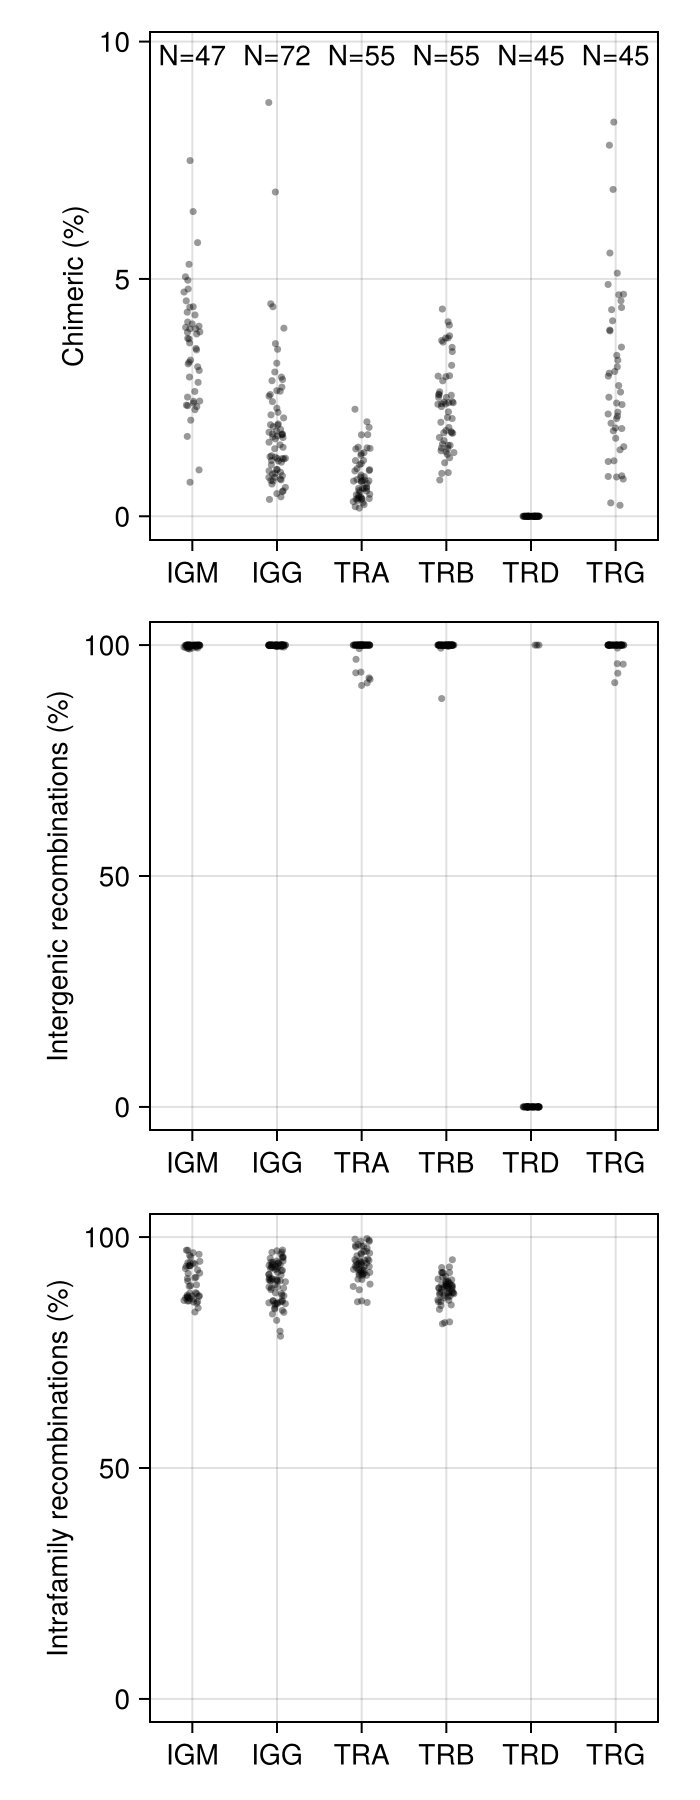

CairoMakie.Screen{IMAGE}


In [7]:
chimerism_percent_figure = Figure(size = (350, 900))
chimerism_percent_axis = Axis(chimerism_percent_figure[1,1],
                            aspect = AxisAspect(1),
                            xticks = (1:6, ["IGM", "IGG", "TRA", "TRB", "TRD", "TRG"]),
                            ylabel = "Chimeric (%)",
                            limits = (0.5, 6.5, -0.5, nothing),
                            yticks = ([0.0, 5.0, 10.0], ["0", "5", "10"]))
intergenic_percent_axis = Axis(chimerism_percent_figure[2,1],
                            aspect = AxisAspect(1),
                            xticks = (1:6, ["IGM", "IGG", "TRA", "TRB", "TRD", "TRG"]),
                            ylabel = "Intergenic recombinations (%)",
                            limits = (0.5, 6.5, -5, 105),
                            yticks = ([0,50,100], ["0", "50", "100"]))
intrafamily_percent_axis = Axis(chimerism_percent_figure[3,1],
                            aspect = AxisAspect(1),
                            xticks = (1:6, ["IGM", "IGG", "TRA", "TRB", "TRD", "TRG"]),
                            ylabel = "Intrafamily recombinations (%)",
                            limits = (0.5, 6.5, -5, 105),
                            yticks = ([0,50,100], ["0", "50", "100"]))
CairoMakie.scatter!(chimerism_percent_axis, chimera_library_freq_df.chain_coord, chimera_library_freq_df.percent, strokecolor = "black", strokewidth = 0, markersize = 5, color = "black", alpha = 0.4)
CairoMakie.text!(chimerism_percent_axis, libraries_per_chain.x_coord, libraries_per_chain.y_coord, text = libraries_per_chain.n_string, align = (:center, :center))
CairoMakie.scatter!(intergenic_percent_axis, intergenic_freq_df.chain_coord, intergenic_freq_df.percent, strokecolor = "black", strokewidth = 0, markersize = 5, color = "black", alpha = 0.4)
CairoMakie.scatter!(intrafamily_percent_axis, same_family_freq_df.chain_coord, same_family_freq_df.percent, strokecolor = "black", strokewidth = 0, markersize = 5, color = "black", alpha = 0.4)
save(joinpath(plots_dir, "chimeric_frequency_summary_scatterplots.svg"), chimerism_percent_figure)
display(chimerism_percent_figure)

# Gene to gene recombination heatmaps (Figure 7)

In [8]:
### perform the clustering used to annotate the heatmaps

left_alleles = collect(Iterators.flatten([[recombination.left_allele for recombination in recombination_array] for recombination_array in parse_recombinations_string.(chimeric.recombinations_degapped)]))
right_alleles = collect(Iterators.flatten([[recombination.right_allele for recombination in recombination_array] for recombination_array in parse_recombinations_string.(chimeric.recombinations_degapped)]))
all_genes = union(unique(map(x->split(x, "*")[1], union(left_alleles, right_alleles))), nonchimeric.v_gene)
hclusts = Dict()
# inverse LCS length based hierarchical clustering of TCR genes
for (ordering, chain) in Base.product(["LCS_hclust"], ["TRA", "TRB", "TRD", "TRG"])
    @info ordering, chain
    sequence_ids, sequences = read_fasta(joinpath(KITDB_dir, chain, "V.fasta"))
    # include only genes which we actually have results for
    genes = [split(el, "*")[1] for el in sequence_ids]
    select = [el in all_genes for el in genes]
    sequence_ids, sequences = sequence_ids[select], sequences[select]
    hclusts["$(ordering)_$(chain)"] = alleles2genehclust(sequence_ids, sequences, dist = inverse_longestcommonsubstring)
end

# levenshtein distance based hierarchical clustering of TCR genes
for (ordering, chain) in Base.product(["edit_hclust"], ["TRA", "TRB", "TRD", "TRG"])
    @info ordering, chain
    sequence_ids, sequences = read_fasta(joinpath(KITDB_dir, chain, "V.fasta"))
    # include only genes which we actually have results for
    genes = [split(el, "*")[1] for el in sequence_ids]
    select = [el in all_genes for el in genes]
    sequence_ids, sequences = sequence_ids[select], sequences[select]
    hclusts["$(ordering)_$(chain)"] = alleles2genehclust(sequence_ids, sequences, dist = lev)
end

# hierarchical clustering of OGRDB human IGHV genes
OGRDB_sequence_ids, OGRDB_sequences = read_fasta(joinpath(OGRDB_dir, "V.fasta"))
# include only genes which we actually have results for
genes = [split(el, "*")[1] for el in OGRDB_sequence_ids]
select = [el in all_genes for el in genes]
OGRDB_sequence_ids, OGRDB_sequences = OGRDB_sequence_ids[select], OGRDB_sequences[select]
hclusts["LCS_hclust_IGM"] = alleles2genehclust(OGRDB_sequence_ids, OGRDB_sequences, dist = inverse_longestcommonsubstring)
hclusts["edit_hclust_IGM"] = alleles2genehclust(OGRDB_sequence_ids, OGRDB_sequences, dist = lev)
hclusts["LCS_hclust_IGG"], hclusts["edit_hclust_IGG"] = hclusts["LCS_hclust_IGM"], hclusts["edit_hclust_IGM"]

[ Info: ("LCS_hclust", "TRA")
[ Info: ("LCS_hclust", "TRB")
[ Info: ("LCS_hclust", "TRD")
[ Info: ("LCS_hclust", "TRG")
[ Info: ("edit_hclust", "TRA")
[ Info: ("edit_hclust", "TRB")
[ Info: ("edit_hclust", "TRD")
[ Info: ("edit_hclust", "TRG")


((hclust = Hclust{Float64}([-10 -2; -6 1; … ; -11 50; 48 51], [0.011111111111111108, 0.016949152542372885, 0.013513513513513514, 0.016666666666666666, 0.019423903319428924, 0.014134808853118715, 0.024436202929957684, 0.02698881697308437, 0.027912365412365407, 0.03263278349016888  …  0.021003111200321153, 0.02519332519332519, 0.030369637712601486, 0.016129032258064516, 0.06042810574386577, 0.061056561327356394, 0.0075315158509279756, 0.014925373134328358, 0.024158964521181336, 0.08321070847378245], [50, 51, 52, 46, 43, 44, 48, 49, 47, 45  …  27, 33, 34, 15, 38, 18, 11, 14, 13, 12], :average), hclust_genes = SubString{String}["IGHV5-10-1", "IGHV5-51", "IGHV6-1", "IGHV4-4", "IGHV4-34", "IGHV4-38-2", "IGHV4-61", "IGHV4-NL1", "IGHV4-59", "IGHV4-39"  …  "IGHV3-48", "IGHV3-69-1", "IGHV3-7", "IGHV3-11", "IGHV3-9", "IGHV3-20", "IGHV2-26", "IGHV2-70D", "IGHV2-70", "IGHV2-5"], gene_distances = [0.0 0.016129032258064516 … 0.08333333333333333 0.09090909090909091; 0.016129032258064516 0.0 … 0.083333

In [9]:
# create hclust order based real and null chimeric V gene co occurrence heatmap plots
heatmap_dir = joinpath(plots_dir, "recombination_heatmaps")
heatmap_dict = Dict()
# numbers which help make nice looking heatmaps
chain2size = Dict("TRA" => (600,600), "TRB" => (700,700), "TRD" => (200,200), "TRG" =>  (200,200), "IGM" => (750,700), "IGG" =>  (750,700))
chain2size_multiplier =       Dict("TRA" => 25, "TRB" => 25, "TRD" => 42, "TRG" =>  42, "IGM" => 25, "IGG" =>  25)
chain2dendogramtextsize =     Dict("TRA" => 20, "TRB" => 20, "TRD" => 15, "TRG" =>  8,  "IGM" => 20, "IGG" =>  20)

function determine_size(m, size_multiplier)
    heatmap_relative_size = 0.8
    heatmap_length = (size_multiplier * m)
    total_length = heatmap_length + (heatmap_length * ((1 - heatmap_relative_size) / heatmap_relative_size))
    return (total_length, total_length)
end

for (ordering, chain) in Base.product(["edit_hclust", "LCS_hclust"], ["TRA", "TRB", "TRD", "TRG", "IGM", "IGG"])
    @info "$chain $ordering"
    if chain == "TRG"
        titlefontsize = 20
    else
        titlefontsize = 40
    end
    @info "Getting null mat"
    # null distribution of chimera V gene co occurrences based on V gene frequences
    null = null_mat(copy(nonchimeric[nonchimeric.chain .== chain,:]),  "v_gene", hclusts["$(ordering)_$(chain)"][2])
    p = cocc_heatmap_dendograms_CairoMakie(null,
                    hclusts["$(ordering)_$(chain)"][1],
                    hclusts["$(ordering)_$(chain)"][2],
                    plot_size = determine_size(size(null)[1], chain2size_multiplier[chain]),
                    title = "Null gene co-occurrences in $(uppercasefirst(chain)) recombinations",
                    titlefontsize = titlefontsize,
                    dendogramticklabelsize = chain2dendogramtextsize[chain])
    heatmap_dict["V_$(ordering)_$(chain)_null"] = (plot = p, matrix = null)

    if chain != "TRD"
        @info "Getting co-occurrence mat"
        # detected chimera V gene co occurrences
        cocc = co_occurrence_mat(copy(chimeric[chimeric.chain .== chain,:]), hclusts["$(ordering)_$(chain)"][2])
        p = cocc_heatmap_dendograms_CairoMakie(cocc,
                        hclusts["$(ordering)_$(chain)"][1],
                        hclusts["$(ordering)_$(chain)"][2],
                        plot_size = determine_size(size(null)[1], chain2size_multiplier[chain]),
                        title = "Gene co-occurrences in $(uppercasefirst(chain)) recombinations",
                        titlefontsize = titlefontsize,
                        dendogramticklabelsize = chain2dendogramtextsize[chain])
        heatmap_dict["V_$(ordering)_$(chain)_cocc"] = (plot = p, matrix = cocc)

        # detected co-occurrences minus the null
        diff_mat = replace(cocc ./ null, NaN => 0)
        p = cocc_heatmap_dendograms_CairoMakie(diff_mat,
                        hclusts["$(ordering)_$(chain)"][1],
                        hclusts["$(ordering)_$(chain)"][2],
                        plot_size = determine_size(size(null)[1], chain2size_multiplier[chain]),
                        title = "Detected / null gene co-occurrences in $(uppercasefirst(chain)) recombinations",
                        titlefontsize = titlefontsize,
                        dendogramticklabelsize = chain2dendogramtextsize[chain])
        heatmap_dict["V_$(ordering)_$(chain)_ratio"] = (plot = p, matrix = diff_mat)
    end
end

# genomically ordered heatmaps do not have dendograms, so they need a separate loop
for (ordering, chain) in Base.product(["genomic"], ["TRA", "TRB", "TRG", "TRD", "IGM", "IGG"])
    @info "$chain $ordering"
    if chain == "TRG"
        titlefontsize = 5
    else
        titlefontsize = 10
    end
    @info "Getting null mat"
    # null distribution of chimera V gene co occurrences based on V gene frequences
    null = null_mat(copy(nonchimeric[nonchimeric.chain .== chain,:]),  "v_gene", gene_order["V_genomic_$(chain)"])
    p = cocc_heatmap(null,
                    gene_order["V_genomic_$(chain)"],
                    plot_size = chain2size[chain],
                    title = "$(uppercasefirst(chain)) null chimeras, $(ordering) order",
                    titlefontsize = titlefontsize)
    heatmap_dict["V_$(ordering)_$(chain)_null"] = (plot = p, matrix = null)
    if chain != "TRD"
        @info "Getting co-occurrence mat"
        # detected chimera V gene co occurrences
        cocc = co_occurrence_mat(copy(chimeric[chimeric.chain .== chain,:]), gene_order["V_genomic_$(chain)"])
        p = cocc_heatmap(cocc,
                        gene_order["V_genomic_$(chain)"],
                        plot_size = chain2size[chain],
                        title = "$(uppercasefirst(chain)) detected chimeras, $(ordering) order",
                        titlefontsize = titlefontsize)
        heatmap_dict["V_$(ordering)_$(chain)_cocc"] = (plot = p, matrix = cocc)
        # detected co-occurrences minus the null
        diff_mat = replace(cocc ./ null, NaN => 0)
        p = cocc_heatmap(diff_mat,
                        gene_order["V_genomic_$(chain)"],
                        plot_size = chain2size[chain],
                        title = "$(uppercasefirst(chain)) detected / null chimeras, $(ordering) order",
                        titlefontsize = titlefontsize)
        heatmap_dict["V_$(ordering)_$(chain)_ratio"] = (plot = p, matrix = diff_mat)
    end
end

# write plots to file
for ordering in ["edit_hclust", "LCS_hclust", "genomic"]
    for chain in ["TRA", "TRB", "TRG", "TRD", "IGM", "IGG"]
        for mat_type in ["null", "cocc", "ratio"]
            if ! (((chain == "TRD") & (mat_type == "cocc")) | ((chain == "TRD") & (mat_type == "ratio")))
                if ordering == "genomic"
                    Plots.savefig(Plots.plot(heatmap_dict["V_$(ordering)_$(chain)_$(mat_type)"].plot ,size = chain2size[chain]), joinpath(heatmap_dir, "V_$(ordering)_$(chain)_$(mat_type).pdf"))
                else
                    save(joinpath(heatmap_dir, "V_$(ordering)_$(chain)_$(mat_type).pdf"), heatmap_dict["V_$(ordering)_$(chain)_$(mat_type)"].plot)
                end
            end
        end
    end
end

[ Info: TRA edit_hclust
[ Info: Getting null mat
┌ Warning: SubString[] have no known order and will be ignored
└ @ Main ~/ben/chimera_detection/chimera_detection/src/heatmap.jl:49
[ Info: Getting co-occurrence mat
[ Info: TRA LCS_hclust
[ Info: Getting null mat
┌ Warning: SubString[] have no known order and will be ignored
└ @ Main ~/ben/chimera_detection/chimera_detection/src/heatmap.jl:49
[ Info: Getting co-occurrence mat
[ Info: TRB edit_hclust
[ Info: Getting null mat
┌ Warning: SubString[] have no known order and will be ignored
└ @ Main ~/ben/chimera_detection/chimera_detection/src/heatmap.jl:49
[ Info: Getting co-occurrence mat
[ Info: TRB LCS_hclust
[ Info: Getting null mat
┌ Warning: SubString[] have no known order and will be ignored
└ @ Main ~/ben/chimera_detection/chimera_detection/src/heatmap.jl:49
[ Info: Getting co-occurrence mat
[ Info: TRD edit_hclust
[ Info: Getting null mat
┌ Warning: SubString[] have no known order and will be ignored
└ @ Main ~/ben/chimera_detecti

In [10]:
# if chimerism was a real biological phenomenon, we would expect the left parent to be closer to the telomere than the right parent
# lower index in matrix = closer to D genes. Row indices are left parents
# So for genomic chimeras, we would expect larger numbers with higher row indices (left parent further from Ds) plus lower column indices (right parent closer to Ds)
# therefore, genomic chimeras would add to the lower left part of the count matrix
genomic_chimerism_sums = DataFrame()
for mat_type in ["cocc", "null", "ratio"]
    for ordering in ["genomic"]
        for chain in ["TRA", "TRB", "TRG", "IGM", "IGG"]
            s = "V_$(ordering)_$(chain)_$(mat_type)"
            t = heatmap_dict[s]
            upperright = round(upperright_sum(t.matrix), digits = 4)
            lowerleft = round(lowerleft_sum(t.matrix), digits = 4)
            genomic_chimerism_sums = vcat(genomic_chimerism_sums, DataFrame(order = "genomic", chain = chain, matrix = mat_type, sum_type = "lower_left", sum = lowerleft))
            genomic_chimerism_sums = vcat(genomic_chimerism_sums, DataFrame(order = "genomic", chain = chain, matrix = mat_type, sum_type = "upper_left", sum = upperright))
            println("$(s) lower left $(lowerleft) upper right $(upperright)")
        end
    end
end
genomic_chimerism_sums

V_genomic_TRA_cocc lower left 0.4825 upper right 0.5078
V_genomic_TRB_cocc lower left 0.5026 upper right 0.4962
V_genomic_TRG_cocc lower left 0.5018 upper right 0.494
V_genomic_IGM_cocc lower left 0.4958 upper right 0.5021
V_genomic_IGG_cocc lower left 0.4863 upper right 0.5132
V_genomic_TRA_null lower left 0.486 upper right 0.486
V_genomic_TRB_null lower left 0.4881 upper right 0.4881
V_genomic_TRG_null lower left 0.4258 upper right 0.4258
V_genomic_IGM_null lower left 0.4876 upper right 0.4876
V_genomic_IGG_null lower left 0.4871 upper right 0.4871
V_genomic_TRA_ratio lower left 716.7824 upper right 758.9635
V_genomic_TRB_ratio lower left 1199.3775 upper right 1167.6373
V_genomic_TRG_ratio lower left 27.6983 upper right 27.6165
V_genomic_IGM_ratio lower left 1133.1211 upper right 1186.1273
V_genomic_IGG_ratio lower left 1178.875 upper right 1234.9256


Row,order,chain,matrix,sum_type,sum
,String,String,String,String,Float64
1,genomic,TRA,cocc,lower_left,0.4825
2,genomic,TRA,cocc,upper_left,0.5078
3,genomic,TRB,cocc,lower_left,0.5026
4,genomic,TRB,cocc,upper_left,0.4962
5,genomic,TRG,cocc,lower_left,0.5018
6,genomic,TRG,cocc,upper_left,0.494
7,genomic,IGM,cocc,lower_left,0.4958
8,genomic,IGM,cocc,upper_left,0.5021
9,genomic,IGG,cocc,lower_left,0.4863


# Gene to gene edit distance vs chimerism rate (Supplementary Figure 2)

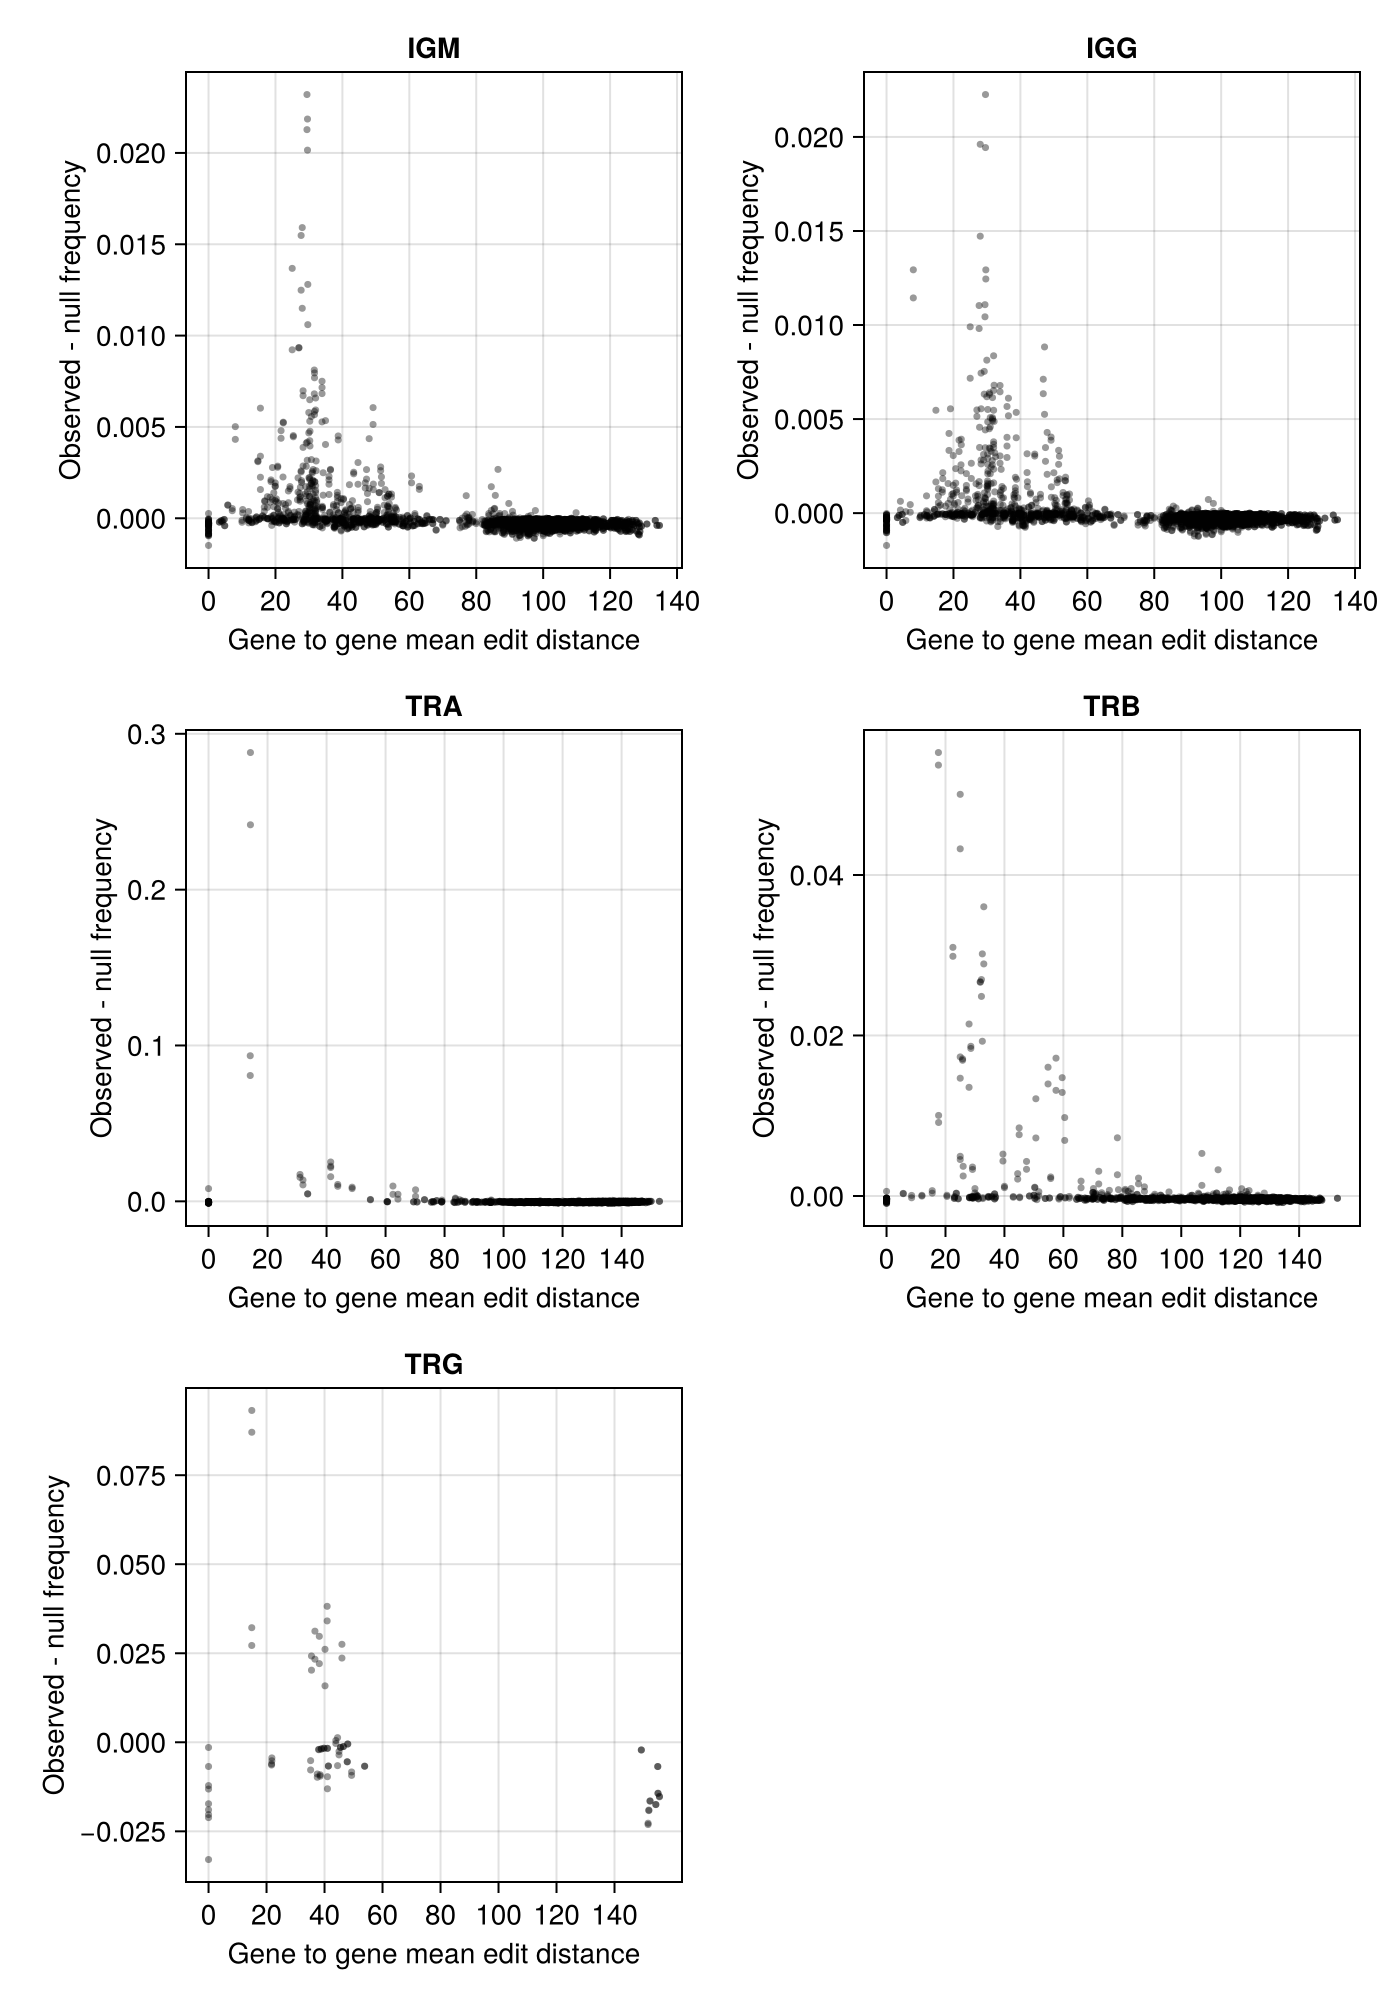

CairoMakie.Screen{SVG}


In [11]:
f = CairoMakie.Figure(size = (700,1000))

IGM_oe = CairoMakie.Axis(f[1, 1], title = "IGM", xlabel = "Gene to gene mean edit distance", ylabel = "Observed - null frequency", xticks=collect(0:20:140), aspect = 1)
IGG_oe = CairoMakie.Axis(f[1, 2], title = "IGG", xlabel = "Gene to gene mean edit distance", ylabel = "Observed - null frequency", xticks=collect(0:20:140), aspect = 1)
TRA_oe = CairoMakie.Axis(f[2, 1], title = "TRA", xlabel = "Gene to gene mean edit distance", ylabel = "Observed - null frequency", xticks=collect(0:20:140), aspect = 1)
TRB_oe = CairoMakie.Axis(f[2, 2], title = "TRB", xlabel = "Gene to gene mean edit distance", ylabel = "Observed - null frequency", xticks=collect(0:20:140), aspect = 1)
TRG_oe = CairoMakie.Axis(f[3, 1], title = "TRG", xlabel = "Gene to gene mean edit distance", ylabel = "Observed - null frequency", xticks=collect(0:20:140), aspect = 1)

chain = "IGM"
edit_dist = vcat(hclusts["edit_hclust_$(chain)"].gene_distances...)
ct_normalized = vcat(heatmap_dict["V_edit_hclust_$(chain)_cocc"].matrix...) .- vcat(heatmap_dict["V_edit_hclust_$(chain)_null"].matrix...)
range = maximum(ct_normalized) - minimum(ct_normalized)
IGM_oe.limits = (nothing, nothing, minimum(ct_normalized) - (0.05 * range), maximum(ct_normalized) + (0.05 * range))
CairoMakie.scatter!(IGM_oe, edit_dist, ct_normalized, color = :black, markersize = 5, alpha = 0.4)

chain = "IGG"
edit_dist = vcat(hclusts["edit_hclust_$(chain)"].gene_distances...)
ct_normalized = vcat(heatmap_dict["V_edit_hclust_$(chain)_cocc"].matrix...) .- vcat(heatmap_dict["V_edit_hclust_$(chain)_null"].matrix...)
range = maximum(ct_normalized) - minimum(ct_normalized)
IGG_oe.limits = (nothing, nothing, minimum(ct_normalized) - (0.05 * range), maximum(ct_normalized) + (0.05 * range))
CairoMakie.scatter!(IGG_oe, edit_dist, ct_normalized, color = :black, markersize = 5, alpha = 0.4)

chain = "TRA"
edit_dist = vcat(hclusts["edit_hclust_$(chain)"].gene_distances...)
ct_normalized = vcat(heatmap_dict["V_edit_hclust_$(chain)_cocc"].matrix...) .- vcat(heatmap_dict["V_edit_hclust_$(chain)_null"].matrix...)
range = maximum(ct_normalized) - minimum(ct_normalized)
TRA_oe.limits = (nothing, nothing, minimum(ct_normalized) - (0.05 * range), maximum(ct_normalized) + (0.05 * range))
CairoMakie.scatter!(TRA_oe, edit_dist, ct_normalized, color = :black, markersize = 5, alpha = 0.4)

chain = "TRB"
edit_dist = vcat(hclusts["edit_hclust_$(chain)"].gene_distances...)
ct_normalized = vcat(heatmap_dict["V_edit_hclust_$(chain)_cocc"].matrix...) .- vcat(heatmap_dict["V_edit_hclust_$(chain)_null"].matrix...)
range = maximum(ct_normalized) - minimum(ct_normalized)
TRB_oe.limits = (nothing, nothing, minimum(ct_normalized) - (0.05 * range), maximum(ct_normalized) + (0.05 * range))
CairoMakie.scatter!(TRB_oe, edit_dist, ct_normalized, color = :black, markersize = 5, alpha = 0.4)

chain = "TRG"
edit_dist = vcat(hclusts["edit_hclust_$(chain)"].gene_distances...)
ct_normalized = vcat(heatmap_dict["V_edit_hclust_$(chain)_cocc"].matrix...) .- vcat(heatmap_dict["V_edit_hclust_$(chain)_null"].matrix...)
range = maximum(ct_normalized) - minimum(ct_normalized)
TRG_oe.limits = (nothing, nothing, minimum(ct_normalized) - (0.05 * range), maximum(ct_normalized) + (0.05 * range))
CairoMakie.scatter!(TRG_oe, edit_dist, ct_normalized, color = :black, markersize = 5, alpha = 0.4)
resize_to_layout!(f)
display(f)
save(joinpath(plots_dir, "gene2gene_dist_vs_o-e.svg"), f)

# Database subsampling (Figure 4)

In [12]:
function read_diff_db_results(igdiscover_dirs, libraries, sizes, db2ind; complete_databases = ["PG", "KITDB", "202330-1IMGT-F"])
    seed = 1
    subsample_test_results = DataFrame()#["library", "db_size", "chimeras"])
    subsample_test_chimeras = DataFrame()
    for (library, igdiscover_dir) in zip(libraries, igdiscover_dirs)
        for size in sizes
            println((library, size, seed))
            #chimeric = CSV.read(joinpath(igdiscover_dir, "chimeric-$(size)Vs-$(SEED)seed-10000subsample-filtered.tsv.gz"), DataFrame, delim = "\t")
            CHMMAIRRa_out = CSV.read(joinpath(igdiscover_dir, "CHMMAIRRa_out.PG.$(size)Vs.$(seed)seed.tsv.gz"), DataFrame, delim = "\t")
            chimeric = CHMMAIRRa_out[CHMMAIRRa_out.chimeric,:]
            chimeric[!,"library"] .= library
            chimeric[!,"db_size"] .= "$(size)∈PG"
            subsample_test_chimeras = vcat(subsample_test_chimeras, chimeric, cols = :union)
            subsample_test_results = vcat(subsample_test_results, DataFrame("library" => library, "db_size" => "$(size)∈PG", "chimeras" => nrow(chimeric), "library_reads" => nrow(CHMMAIRRa_out)))
        end
        for complete_database in complete_databases
            CHMMAIRRa_out = CSV.read(joinpath(igdiscover_dir, "CHMMAIRRa_out.$(complete_database).tsv.gz"), DataFrame, delim = "\t");
            chimeric = CHMMAIRRa_out[CHMMAIRRa_out.chimeric,:]
            subsample_test_results = vcat(subsample_test_results, DataFrame("library" => library, "db_size" => complete_database, "chimeras" => nrow(chimeric), "library_reads" => nrow(CHMMAIRRa_out)))
            chimeric[!,"library"] .= library
            chimeric[!,"db_size"] .= complete_database
            subsample_test_chimeras = vcat(subsample_test_chimeras, chimeric, cols = :union)
        end
    end
    subsample_test_results[!,"chimeric(%)"] = subsample_test_results[!,"chimeras"] ./ subsample_test_results[!,"library_reads"] * 100;
    subsample_test_results[!,"db_ind"] .= [db2ind[el] for el in subsample_test_results[!,"db_size"]];
    return subsample_test_results, subsample_test_chimeras
end

read_diff_db_results (generic function with 1 method)

In [13]:
# IML369 dataset
# IGM
IML369_dir = joinpath(igdiscover_dir, "IML369")
IGM_db2ind = Dict("30∈PG" => 1, "40∈PG" => 2, "PG" => 3, "OGRDB" => 4, "IMGT-V-QUEST-F" => 5)
IGM_libraries = ["IML3694_25cycle", "IML3695_25cycle"] # IGM libraries
IGM_igdiscover_dirs = joinpath.(Ref(IML369_dir), Ref("IgM"), IGM_libraries, Ref("final"))
IGM_sizes = [30,40]

# IGG
IGG_db2ind = Dict("30∈PG" => 1, "40∈PG" => 2, "PG" => 3, "OGRDB" => 4, "IMGT-V-QUEST-F" => 5)
IGG_libraries = ["IML3694_acute", "IML3694_convalescent", "IML3694_post-vax", "IML3695_acute", "IML3695_convalescent", "IML3695_post-vax"]
IGG_igdiscover_dirs = joinpath.(Ref(IML369_dir), Ref("IgG"), IGG_libraries, Ref("final"))
IGG_sizes = [30,40]

# GKH TCR dataset
GKH_TCR_dir = joinpath(igdiscover_dir, "GKH_TCR")
TRA_db2ind = Dict("30∈PG" => 1, "40∈PG" => 2, "PG" => 3, "KITDB" => 4, "IMGT-V-QUEST-F" => 5)
TRA_libraries = ["TRA/D01", "TRA/D04", "TRA/D07", "TRA/D11", "TRA/D14"] # TRA libraries
TRA_igdiscover_dirs = joinpath.(Ref(GKH_TCR_dir), TRA_libraries, Ref("final"))
TRA_sizes = [30,40]

TRB_db2ind = Dict("40∈PG" => 1, "50∈PG" => 2, "PG" => 3, "KITDB" => 4, "IMGT-V-QUEST-F" => 5)
TRB_libraries = ["TRB/D01", "TRB/D04", "TRB/D07", "TRB/D11", "TRB/D14"] # TRB libraries
TRB_igdiscover_dirs = joinpath.(Ref(GKH_TCR_dir), TRB_libraries, Ref("final"))
TRB_sizes = [40,50]

TRG_db2ind = Dict("4∈PG" => 1, "6∈PG" => 2, "PG" => 3, "KITDB" => 4, "IMGT-V-QUEST-F" => 5)
TRG_libraries = ["TRG/D01", "TRG/D04", "TRG/D07", "TRG/D11", "TRG/D14"] # TRG libraries
TRG_igdiscover_dirs = joinpath.(Ref(GKH_TCR_dir), TRG_libraries, Ref("final"))
TRG_sizes = [4,6]

IGM_subsample_test_results, IGM_subsample_test_chimeras = read_diff_db_results(IGM_igdiscover_dirs, IGM_libraries, IGM_sizes, IGM_db2ind, complete_databases = ["PG", "OGRDB", "IMGT-V-QUEST-F"]);
IGG_subsample_test_results, IGG_subsample_test_chimeras = read_diff_db_results(IGG_igdiscover_dirs, IGG_libraries, IGG_sizes, IGG_db2ind, complete_databases = ["PG", "OGRDB", "IMGT-V-QUEST-F"]);
TRA_subsample_test_results, TRA_subsample_test_chimeras = read_diff_db_results(TRA_igdiscover_dirs, TRA_libraries, TRA_sizes, TRA_db2ind, complete_databases = ["PG", "KITDB", "IMGT-V-QUEST-F"]);
TRB_subsample_test_results, TRB_subsample_test_chimeras = read_diff_db_results(TRB_igdiscover_dirs, TRB_libraries, TRB_sizes, TRB_db2ind, complete_databases = ["PG", "KITDB", "IMGT-V-QUEST-F"]);
TRG_subsample_test_results, TRG_subsample_test_chimeras = read_diff_db_results(TRG_igdiscover_dirs, TRG_libraries, TRG_sizes, TRG_db2ind, complete_databases = ["PG", "KITDB", "IMGT-V-QUEST-F"]);

("IML3694_25cycle", 30, 1)
("IML3694_25cycle", 40, 1)
("IML3695_25cycle", 30, 1)
("IML3695_25cycle", 40, 1)
("IML3694_acute", 30, 1)
("IML3694_acute", 40, 1)
("IML3694_convalescent", 30, 1)
("IML3694_convalescent", 40, 1)
("IML3694_post-vax", 30, 1)
("IML3694_post-vax", 40, 1)
("IML3695_acute", 30, 1)
("IML3695_acute", 40, 1)
("IML3695_convalescent", 30, 1)
("IML3695_convalescent", 40, 1)
("IML3695_post-vax", 30, 1)
("IML3695_post-vax", 40, 1)
("TRA/D01", 30, 1)
("TRA/D01", 40, 1)
("TRA/D04", 30, 1)
("TRA/D04", 40, 1)
("TRA/D07", 30, 1)
("TRA/D07", 40, 1)
("TRA/D11", 30, 1)
("TRA/D11", 40, 1)
("TRA/D14", 30, 1)
("TRA/D14", 40, 1)
("TRB/D01", 40, 1)
("TRB/D01", 50, 1)
("TRB/D04", 40, 1)
("TRB/D04", 50, 1)
("TRB/D07", 40, 1)
("TRB/D07", 50, 1)
("TRB/D11", 40, 1)
("TRB/D11", 50, 1)
("TRB/D14", 40, 1)
("TRB/D14", 50, 1)
("TRG/D01", 4, 1)
("TRG/D01", 6, 1)
("TRG/D04", 4, 1)
("TRG/D04", 6, 1)
("TRG/D07", 4, 1)
("TRG/D07", 6, 1)
("TRG/D11", 4, 1)
("TRG/D11", 6, 1)
("TRG/D14", 4, 1)
("TRG/D14"

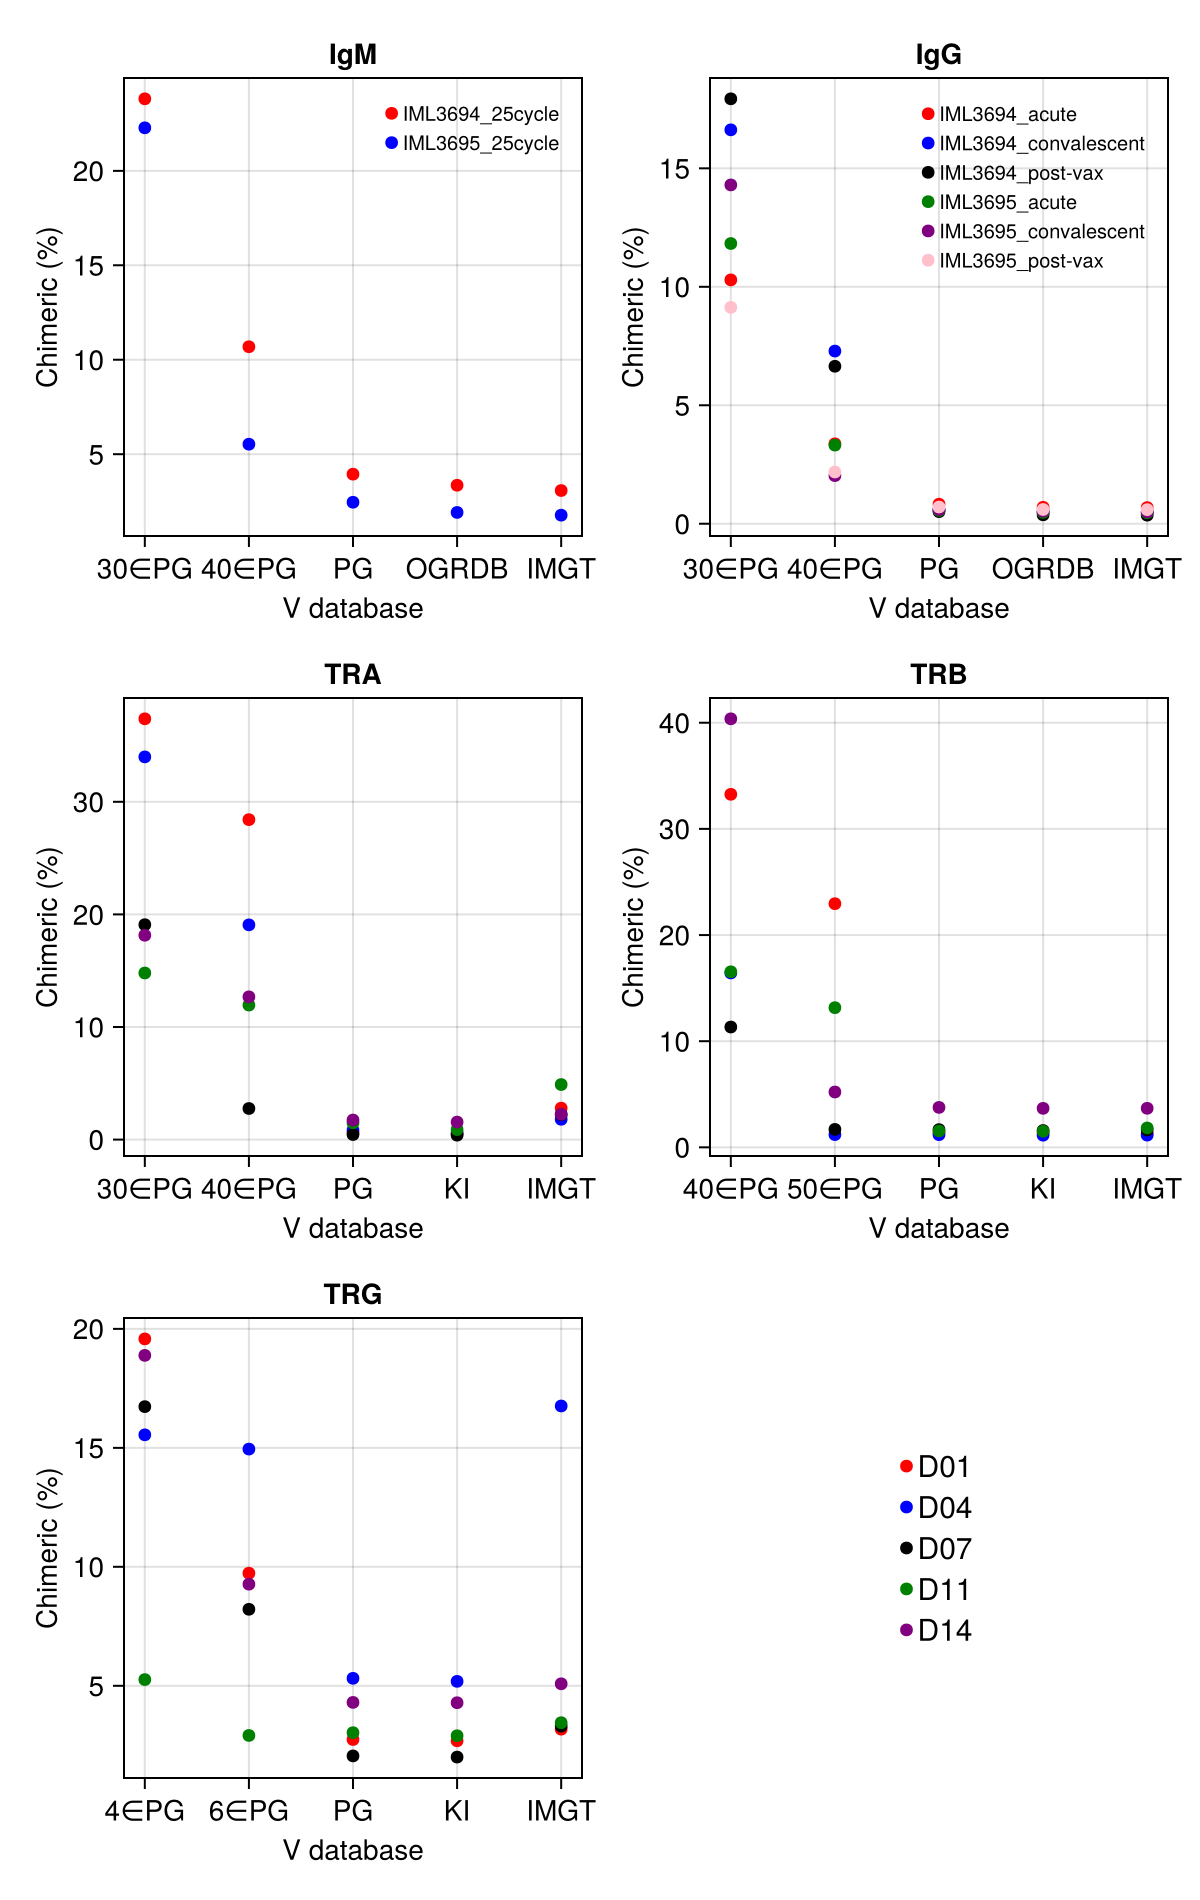

CairoMakie.Screen{SVG}


In [14]:
db_sub_f = Figure(size = (600, 950))
ind2db = Dict(value => key for (key, value) in IGM_db2ind)
ind2db[5] = "IMGT"
db_sub = CairoMakie.Axis(db_sub_f[1,1], ylabel = "Chimeric (%)", xlabel = "V database", xticks = (1:5, [ind2db[i] for i in 1:5]), title = "IgM")
colors = ["red", "blue"]
for (i, library) in enumerate(IGM_libraries)
    df = IGM_subsample_test_results[IGM_subsample_test_results.library .== library,:]
    CairoMakie.scatter!(db_sub, df[!,"db_ind"], df[!,"chimeric(%)"], color = colors[i], label = library)
end
axislegend(db_sub, position = :rt, labelsize = 10, patchsize = (0,0), framevisible = false)

ind2db = Dict(value => key for (key, value) in IGG_db2ind)
ind2db[5] = "IMGT"
db_sub = CairoMakie.Axis(db_sub_f[1,2], ylabel = "Chimeric (%)", xlabel = "V database", xticks = (1:5, [ind2db[i] for i in 1:5]), title = "IgG")
colors = ["red", "blue", "black", "green", "purple", "pink"]
for (i, library) in enumerate(IGG_libraries)
    df = IGG_subsample_test_results[IGG_subsample_test_results.library .== library,:]
    CairoMakie.scatter!(db_sub, df[!,"db_ind"], df[!,"chimeric(%)"], color = colors[i], label = library)
end
axislegend(db_sub, position = :rt, labelsize = 10, patchsize = (0,0), framevisible = false)

ind2db = Dict(value => key for (key, value) in TRA_db2ind)
ind2db[5] = "IMGT"
ind2db[4] = "KI"
db_sub = CairoMakie.Axis(db_sub_f[2,1], ylabel = "Chimeric (%)", xlabel = "V database", xticks = (1:5, [ind2db[i] for i in 1:5]), title = "TRA")
colors = ["red", "blue", "black", "green", "purple"]
for (i, library) in enumerate(TRA_libraries)
    df = TRA_subsample_test_results[TRA_subsample_test_results.library .== library,:]
    CairoMakie.scatter!(db_sub, df[!,"db_ind"], df[!,"chimeric(%)"], color = colors[i], label = library)
end

ind2db = Dict(value => key for (key, value) in TRB_db2ind)
ind2db[5] = "IMGT"
ind2db[4] = "KI"
db_sub = CairoMakie.Axis(db_sub_f[2,2], ylabel = "Chimeric (%)", xlabel = "V database", xticks = (1:5, [ind2db[i] for i in 1:5]), title = "TRB")
colors = ["red", "blue", "black", "green", "purple"]
for (i, library) in enumerate(TRB_libraries)
    df = TRB_subsample_test_results[TRB_subsample_test_results.library .== library,:]
    CairoMakie.scatter!(db_sub, df[!,"db_ind"], df[!,"chimeric(%)"], color = colors[i], label = library)
end

ind2db = Dict(value => key for (key, value) in TRG_db2ind)
ind2db[5] = "IMGT"
ind2db[4] = "KI"
db_sub = CairoMakie.Axis(db_sub_f[3,1], ylabel = "Chimeric (%)", xlabel = "V database", xticks = (1:5, [ind2db[i] for i in 1:5]), title = "TRG")
colors = ["red", "blue", "black", "green", "purple"]
for (i, library) in enumerate(TRG_libraries)
    df = TRG_subsample_test_results[TRG_subsample_test_results.library .== library,:]
    CairoMakie.scatter!(db_sub, df[!,"db_ind"], df[!,"chimeric(%)"], color = colors[i], label = library)
end

# automatic legend was messing up the layout, so we manually add a legend
leg_ax = CairoMakie.Axis(db_sub_f[3,2], limits = (0.0, 0.5, 0, 0.5))
hidedecorations!(leg_ax)
hidespines!(leg_ax)
CairoMakie.scatter!(leg_ax, [1], [1], color = "red",    label = "D01")
CairoMakie.scatter!(leg_ax, [1], [1], color = "blue",   label = "D04")
CairoMakie.scatter!(leg_ax, [1], [1], color = "black",  label = "D07")
CairoMakie.scatter!(leg_ax, [1], [1], color = "green",  label = "D11")
CairoMakie.scatter!(leg_ax, [1], [1], color = "purple", label = "D14")
axislegend(leg_ax, position = :cc, labelsize = 15, patchsize = (0,0), framevisible = false)

# make everything square
rowsize!(db_sub_f.layout, 1, Aspect(1, 1))
rowsize!(db_sub_f.layout, 2, Aspect(1, 1))
rowsize!(db_sub_f.layout, 3, Aspect(1, 1))

display(db_sub_f)
save(joinpath(plots_dir, "IgMG_TRABG_subsampling_v_genotype.svg"), db_sub_f)

# Plot recombination location distributions

In [15]:
# get gene lengths
Vgene2length = Dict()
# add OGRDB IGHVs
IGHV_refnames, IGHV_refseqs = read_fasta(joinpath(OGRDB_dir, "V.fasta"))
IGHV_df = DataFrame(v_call = IGHV_refnames, length = length.(IGHV_refseqs))
IGHV_df[!,"gene"] .= map(x->split(x, "*")[1], IGHV_df.v_call)
IGHV_df = unique(IGHV_df, :gene)
IGHV_gene2length = Dict(zip(IGHV_df.gene, IGHV_df.length))
# append OGRDB gene2lengths to Dict
merge!(Vgene2length, IGHV_gene2length)
for locus in ["TRA", "TRB", "TRG"]
    V_refnames, V_refseqs = read_fasta(joinpath(KITDB_dir, locus, "V.fasta"))
    V_df = DataFrame(v_call = V_refnames, length = length.(V_refseqs))
    V_df[!,"gene"] .= map(x->split(x, "*")[1], V_df.v_call)
    V_df = unique(V_df, :gene)
    TCR_V_gene2length = Dict(zip(V_df.gene, V_df.length))
    merge!(Vgene2length, TCR_V_gene2length)
end

In [16]:
chimeric[!,"from_split_normpos"] .= map(x -> x[1].left_pos_degapped / Vgene2length[split(x[1].left_allele, "*")[1]], parse_recombinations_string.(chimeric.recombinations_degapped));
chimeric[!,"to_split_normpos"] .= map(x -> x[1].right_pos_degapped / Vgene2length[split(x[1].right_allele, "*")[1]], parse_recombinations_string.(chimeric.recombinations_degapped));

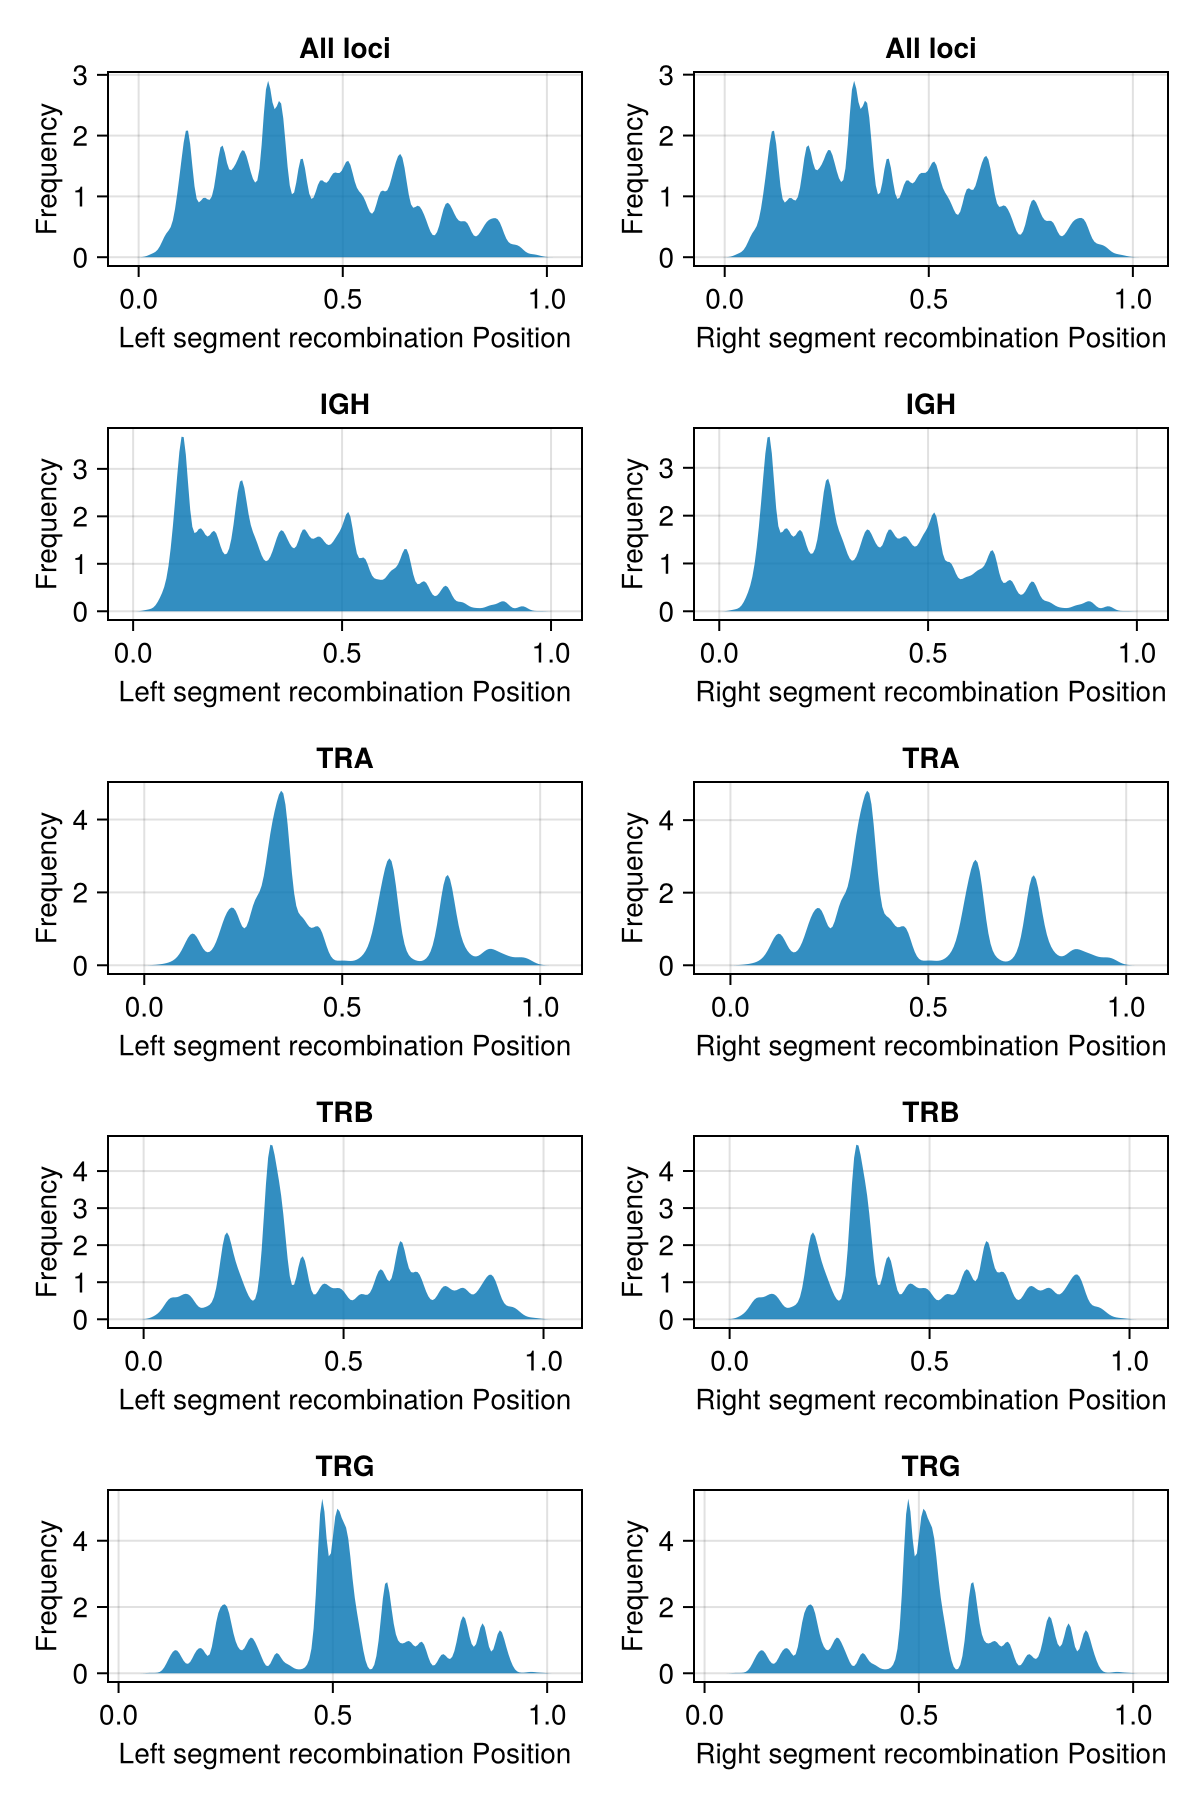

CairoMakie.Screen{IMAGE}


In [17]:
recombination_pos_f = Figure(size = (600, 900))
all_loci_from_ax = Axis(recombination_pos_f[1,1], xlabel = "Left segment recombination Position", ylabel = "Frequency", title = "All loci")
all_loci_to_ax = Axis(recombination_pos_f[1,2], xlabel = "Right segment recombination Position", ylabel = "Frequency", title = "All loci")

CairoMakie.density!(all_loci_from_ax, chimeric.from_split_normpos)
CairoMakie.density!(all_loci_to_ax, chimeric.to_split_normpos)

for (i, locus) in enumerate(["IGH", "TRA", "TRB", "TRG"])
    ax1 = Axis(recombination_pos_f[1+i,1], xlabel = "Left segment recombination Position", ylabel = "Frequency", title = locus)
    ax2 = Axis(recombination_pos_f[1+i,2], xlabel = "Right segment recombination Position", ylabel = "Frequency", title = locus)

    CairoMakie.density!(ax1, chimeric[chimeric.locus .== locus, :from_split_normpos])
    CairoMakie.density!(ax2, chimeric[chimeric.locus .== locus, :to_split_normpos])
end
save(joinpath(plots_dir, "recombination_positions_distributions.svg"), recombination_pos_f)
display(recombination_pos_f)